In [167]:
import quake_envs
import matplotlib.pyplot as plt
import seaborn as sns
from quake_envs.simulations.building_funcs import Building, BuildingAction
from quake_envs.simulations.road_funcs import Road, RoadAction
import numpy as np
from shapely.geometry import Polygon, LineString
import matplotlib.patches as patches
import gymnasium as gym

In [168]:
env = gym.make("quake-res-30-v1").unwrapped

In [169]:
env.reset()

(array([  2.,  59.,  77.,  31.,  27.,  93., 345.,  50.,   6.,  91.,  43.,
         25., 192., 178., 190., 152.,  75., 139., 152., 152., 152.,  37.,
        152.,  21.,  13., 152.,  36.,   3., 152.,   0.], dtype=float32),
 {'q': {'community_robustness': 0.3503592546692085,
   'community_robustness_econ': 0.22436766981647357,
   'community_robustness_crit': 0.066,
   'community_robustness_health': 0.059991584852734925,
   'community': 0.3503592546692085,
   'econ': 0.22436766981647357,
   'crit': 0.066,
   'health': 0.059991584852734925},
  'q_econ_components': {'income': 0.6508070454142981,
   'bldg': 0.07488004899165238,
   'road': 0.9838943279801247,
   'reloc': 0.34484106843370876,
   'traffic': 1.0},
  'completions': {'bldg_repairs': [False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False],
   'road_repairs': [False,
    False,
    False,
    False,
    False,
    False,
    Fals

In [170]:
buildings = env.resilience.buildings_objs
building = buildings[6]
building

In [171]:
# building = Building(
#   geometry=Polygon([(0, 0), (0, 10), (10, 10), (10, 0)]),
#   id="test_building",
#   occtype="COM2",
#   str_type="S5L",
#   num_stories=2,
#   sqft=1000,
#   is_essential=False,
#   verbose=False,
#   calc_debris=True,
#   stoch_ds=True,
#   stoch_rt=True,
#   stoch_cost=True,
#   stoch_inc_loss=True,
#   stoch_loss_of_function=True,
#   stoch_relocation_cost=True
# )

# road = Road(
#   geometry=LineString([(0, 0), (0, 10), (10, 10), (10, 0)]),
#   id="test_road",
#   hazus_road_class="HRD1",
#   verbose=False,
#   calc_debris=True,
#   stoch_ds=True,
#   stoch_rt=True,
#   stoch_cost=True,
#   init_node=0,
#   term_node=1,
#   flow=1.0,
#   capacity=1000,
#   length_miles=1.0,
#   hazus_bridge_class="None",
#   is_bridge=False,
#   time_step_duration=5,
#   traffic_idx = 0
# )

In [ ]:
def repair_building(building:Building):
    repair_times = []
    incomes = []
    relocation_cost = []
    repair_cost = []
    actions= []

    while building.has_debris:
        action = np.random.choice(
            [BuildingAction.REPAIR, BuildingAction.DO_NOTHING],
            p=[0.5, 0.5]
        )
        repair_times.append(building.current_repair_time)
        incomes.append(building.current_income)
        relocation_cost.append(building.current_relocation_cost)
        repair_cost.append(building.current_structural_repair_cost)
        building.step(action)
        actions.append(action)
    while building.current_repair_time > 0:
        action = np.random.choice(
            [BuildingAction.REPAIR, BuildingAction.DO_NOTHING],
            p=[0.5, 0.5]
        )
        repair_times.append(building.current_repair_time)
        incomes.append(building.current_income)
        relocation_cost.append(building.current_relocation_cost)
        repair_cost.append(building.current_structural_repair_cost)
        building.step(action)
        actions.append(action)
        print(building.current_relocation_cost)
    while building.current_income != building.max_income:
        action = np.random.choice(
            [BuildingAction.REPAIR, BuildingAction.DO_NOTHING],
            p=[0.5, 0.5]
        )
        repair_times.append(building.current_repair_time)
        incomes.append(building.current_income)
        relocation_cost.append(building.current_relocation_cost)
        repair_cost.append(building.current_structural_repair_cost)
        building.step(action)
        actions.append(action)
    return repair_times, incomes, relocation_cost, repair_cost, actions


def repair_road(road: Road):
    repair_times = []
    capacity_reductions = []
    repair_costs = []
    actions = []

    while road.current_repair_time > 0:
        repair_times.append(road.current_repair_time)
        capacity_reductions.append(road.capacity_red_damage_state)
        repair_costs.append(road.current_repair_cost)
        actions.append(RoadAction.REPAIR)  # or RoadAction.DO_NOTHING if appropriate
        road.step(RoadAction.REPAIR, dependant_buildings=[])
    return repair_times, capacity_reductions, repair_costs, actions

In [173]:
# building.reset(damage_state_probs=np.array([0.0, 0.0, 0.0, 0.0, 1.0]), debris_capacity_reduction=1.0)
# road.reset(damage_state=4, capacity_red_debris=0.0)

In [174]:
def plot_single_road_repair(road, figsize=(10, 6)):
    """
    Plots repair metrics over time for a single road using the `repair_road` simulation.
    """
    repair_times, capacity_reductions, repair_costs, actions = repair_road(road)

    timesteps = list(range(len(repair_times)))

    def normalize_to_range(values, max_val=4, min_val=None):
        min_val = min_val if min_val is not None else min(values)
        max_range = max(values) if max(values) != min_val else min_val + 1
        return [max_val * (v - min_val) / (max_range - min_val) for v in values]

    rt_norm = normalize_to_range(repair_times)
    cr_norm = normalize_to_range(capacity_reductions)
    rcost_norm = normalize_to_range(repair_costs)

    sns.set(style="whitegrid", context="notebook")
    fig, ax = plt.subplots(figsize=figsize)

    # Shaded phase regions
    try:
        t_rep = -1
        for t in repair_times:
            if t == 0.0:
                t_rep = repair_times.index(t)
                break
        t_start_repair = next(i for i, t in enumerate(repair_times) if t < max(repair_times))
    except StopIteration:
        t_start_repair = 0

    ax.axvspan(xmin=timesteps[0], xmax=len(timesteps), color='red', alpha=0.1, label='Repair Phase')

    # ax.axvspan(xmin=t_start_repair-1, xmax=len(timesteps), color='orange', alpha=0.1, label='Repair Phase')

    # Plot metrics
    ax.plot(timesteps, rt_norm, label='Repair Time', linestyle='-', marker='o')
    ax.plot(timesteps, rcost_norm, label='Repair Cost', linestyle='--', marker='^')
    ax.plot(timesteps, cr_norm, label='Capacity Reduction', linestyle='-.', marker='s')

    # Decoration
    rect = patches.Rectangle((0, 4.75), timesteps[-1], 0.5, linewidth=1, edgecolor='black', facecolor='white', zorder=25)
    ax.add_patch(rect)

    for t in timesteps:
        if actions[t] == RoadAction.REPAIR:
            ax.scatter(t, 5, s=30, marker='>', color='purple', zorder=50)
        elif actions[t] == RoadAction.DO_NOTHING:
            ax.scatter(t, 5, s=30, marker='o', color='grey', zorder=50)

    ax.set_ylim(0, 5.5)
    ax.set_title(f"Road Repair Performance Over Time", fontsize=16)
    ax.set_xlabel("Timestep", fontsize=14)
    ax.set_ylabel("Normalized Metric Value", fontsize=14)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [175]:

def plot_single_building_repair(building, figsize=(10, 6)):
    """
    Plots repair metrics over time for a single building using the `repair_building` simulation.
    """
    repair_times, incomes, relocation_costs, repair_costs, actions = repair_building(building)
    # print(incomes)
    # print(building.max_income)

    timesteps = list(range(len(repair_times)))

    def normalize_to_range(values, max_val=4, min_val=None):
        min_val = min_val if min_val is not None else min(values)
        max_range = max(values) if max(values) != min_val else min_val + 1
        return [max_val * (v - min_val) / (max_range - min_val) for v in values]

    # Normalize for plotting (keep relative shapes, scale to same range)
    rt_norm = normalize_to_range(repair_times)
    inc_norm = normalize_to_range(incomes, min_val=min(incomes))
    reloc_norm = normalize_to_range(relocation_costs)
    rcost_norm = normalize_to_range(repair_costs)

    sns.set(style="whitegrid", context="notebook")
    fig, ax = plt.subplots(figsize=figsize)

    # Shaded phase regions
    try:
        t_debris_end = next(i for i, t in enumerate(repair_times) if t < max(repair_times))
        t_rep = -1
        for t in repair_times:
            if t==0.0:
                t_rep = repair_times.index(t)
                break
    except StopIteration:
        t_debris_end = 0

    ax.axvspan(xmin=timesteps[0], xmax=t_debris_end-1, color='orange', alpha=0.1, label='Debris Clearing Phase')
    if t_rep != -1:
        ax.axvspan(xmin=t_debris_end-1, xmax=t_rep-1, color='red', alpha=0.1, label='Repair Phase')
        ax.axvspan(xmin=t_rep-1, xmax=len(timesteps)-1, color='green', alpha=0.1, label='Repair Phase')
    else:
        ax.axvspan(xmin=t_debris_end-1, xmax=len(timesteps), color='red', alpha=0.1, label='Repair Phase')

    # Plot metrics
    ax.plot(timesteps, rt_norm, label='Repair Time', linestyle='-', marker='o')
    ax.plot(timesteps, rcost_norm, label='Repair Cost', linestyle='--', marker='^')
    ax.plot(timesteps, inc_norm, label='Income', linestyle=':', marker='d')
    ax.plot(timesteps, reloc_norm, label='Relocation Cost', linestyle='-.', marker='x')

    # Decoration
    rect = patches.Rectangle((0, 4.75), timesteps[-1], 0.5, linewidth=1, edgecolor='black', facecolor='white', zorder=25)
    ax.add_patch(rect)

    for t in timesteps:
        if actions[t] == BuildingAction.REPAIR:
            ax.scatter(t, 5, s=30, marker='>', color='purple', zorder=50)
        elif actions[t] == BuildingAction.DO_NOTHING:
            ax.scatter(t, 5, s=30, marker='o', color='grey', zorder=50)


    ax.set_ylim(0, 5.5)
    ax.set_title(f"Building: {building.occtype} Repair Performance Over Time", fontsize=16)
    ax.set_xlabel("Timestep", fontsize=14)
    ax.set_ylabel("Normalized Metric Value", fontsize=14)
    ax.legend()
    plt.tight_layout()
    plt.show()

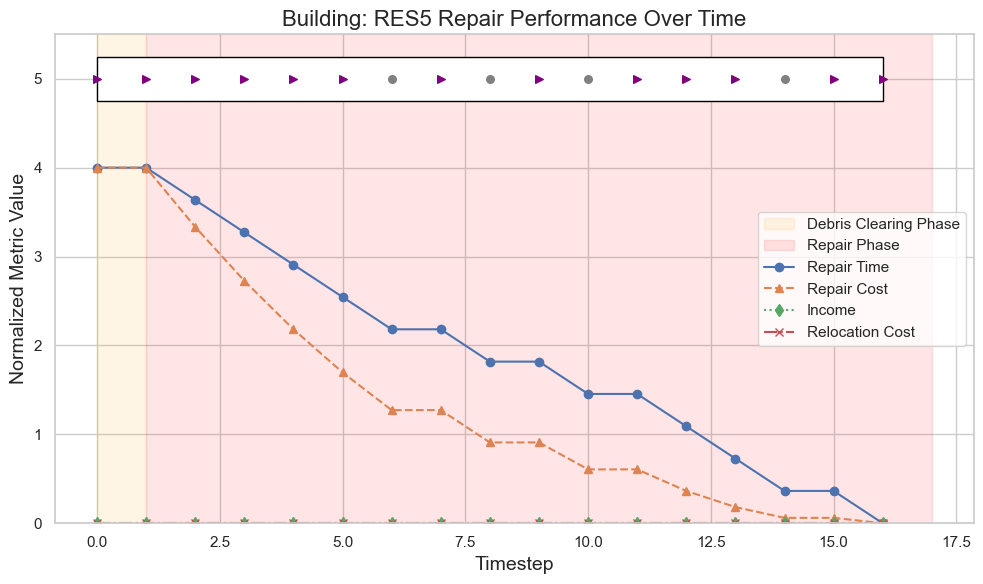

In [176]:
plot_single_building_repair(building)

# plot_single_road_repair(road)